# Mass Transports

Investigation of Gulf Stream separation misbehaviour: https://github.com/COSIMA/access-om2/issues/151

Based on https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/strait_transports/strait_transports.ipynb

Transport diagnostics for flow through major straits.

## Theory

Formally, mass transports are given by
$$T_x = \rho u  $$
$$T_y = \rho v  $$

Mass transports are diagnostics that are calculated online by the model:

|variable|long name|units|dimensions|
|-|
|tx_trans|T-cell i-mass transport|Sv|(time,st_ocean,xu_ocean,yt_ocean)|
|ty_trans|T-cell j-mass transport|Sv|(time,st_ocean,xt_ocean,yu_ocean)|


These variables are saved in `ocean.nc` files.

## Calculation

In [1]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
from dask.distributed import Client

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
# only retain 0.1deg
for key in list(exptdata.exptdict.keys()):
    if key is not '01deg':
        del exptdata.exptdict[key]
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.
Available exptdata keys:  ['01deg']


In [3]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [4]:
exptdata.exptdict

OrderedDict([('01deg',
              {'model': 'access-om2-01',
               'expt': '01deg_jra55v13_iaf',
               'desc': 'ACCESS-OM2-01',
               'n_files': None,
               'time_units': 'days since 0001-01-01',
               'offset': None,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf'})])

In [5]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [6]:
try:
    data
except NameError:
    data = copy.deepcopy(exptdata.exptdict)  # to store fields under the same keys as exptdata.exptdict

In [7]:
# Strait locations: [minlon, maxlon, minlat, maxlat]
# Add as many as you like, but they must be zonal or meridional
data['01deg']['straits'] = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
#             ('Drake Passage', [-69.9, -69.9, -71.6, -51.0]),
#             ('Lombok Strait', [-244.3, -243.8, -8.37, -8.37]),
#             ('Ombai Strait',  [-234.9, -234.9, -8.86, -8.27]),
#             ('Timor Strait',  [-232.6, -232.6, -13.96, -8.37]),
#             ('Bering Strait', [-172, -167, 65.8, 65.8]),
            ('Denmark Strait',[-42, -22, 65.8, 65.8]),
            ('East Taiwan Channel',[121.7-360, 124-360, 24.4, 24.4]),  # WOCE PCM-1 array between Taiwan and Iriomote (JohnsLeeZhangZantoppLiuYang2001a)
            ('Florida Current',[-81, -78.8, 26.7, 26.7])  # MeinenBaringerGarcia2010a
            ])
# data['025deg']['straits'] = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
#             ('Drake Passage', [-69.9, -69.9, -71.6, -51.0]),
#             ('Lombok Strait', [-244.5, -243.5, -8.22, -8.22]),
#             ('Ombai Strait',  [-235.5, -235.5, -9.21, -8.47]),
#             ('Timor Strait',  [-233, -233, -13.86, -8.71]),
#             ('East Taiwan Channel',[121.7-360, 124-360, 24.4, 24.4]),  # WOCE PCM-1 array between Taiwan and Iriomote (JohnsLeeZhangZantoppLiuYang2001a)
#             ('Florida Current',[-81, -78.8, 26.7, 26.7])  # MeinenBaringerGarcia2010a
#             ])
# data['1deg']['straits'] = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
#             ('Drake Passage', [-69.9, -69.9, -71.6, -51.0]),
#             ('Lombok Strait', [-245, -242, -8.33, -8.33]),
#             ('Ombai Strait',  [-237, -237, -10.33, -8.33]),
#             ('Timor Strait',  [-233, -233, -13.9, -9]),
#             ('East Taiwan Channel',[121.7-360, 125-360, 24.4, 24.4]),  # xmax extended by 1deg as in TsengLinChenThompsonBentsenBoningBozecCassouChassignet2016a
#             ('Florida Current',[-81, -77.8, 26.7, 26.7]) # xmax extended  # MeinenBaringerGarcia2010a
# ])

In [8]:
# load data
for ekey in data.keys():
    print(ekey)
    e = data[ekey]
    if 'tx_trans_int_z' not in e:
        e['tx_trans_int_z'] = cc.get_nc_variable(e['expt'],'ocean_month.nc','tx_trans_int_z',use_cache=True,
                                     n=e['n_files'], time_units=e['time_units'], offset=e['offset'])
        e['ty_trans_int_z'] = cc.get_nc_variable(e['expt'],'ocean_month.nc','ty_trans_int_z',use_cache=True,
                                     n=e['n_files'], time_units=e['time_units'], offset=e['offset'])
    if 'tx_trans' not in e:
        e['tx_trans'] = cc.get_nc_variable(e['expt'],'ocean.nc','tx_trans',use_cache=True,
                                     n=e['n_files'], time_units=e['time_units'], offset=e['offset'])
        e['ty_trans'] = cc.get_nc_variable(e['expt'],'ocean.nc','ty_trans',use_cache=True,
                                     n=e['n_files'], time_units=e['time_units'], offset=e['offset'])

01deg
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_month.nc_tx_trans_int_z_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_month.nc_ty_trans_int_z_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_tx_trans_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_ty_trans_None_days-since-0001-01-01_None_False.pkl


01deg
Denmark Strait
East Taiwan Channel
Florida Current


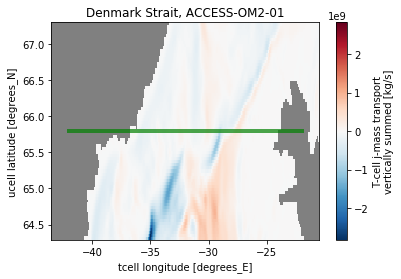

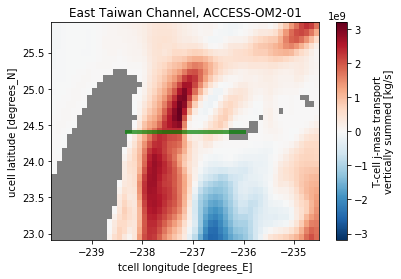

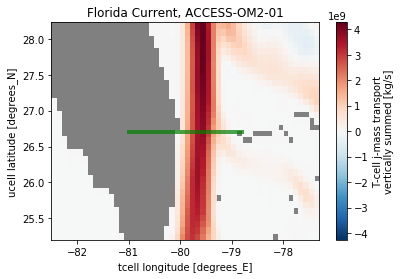

In [9]:
# plot maps of transect locations (just final time shown)
m = 1.5 # margin (degrees)
for ekey in data.keys():
    print(ekey)
    e = data[ekey]
    for strait, (xmin, xmax, ymin, ymax) in e['straits'].items():
        print(strait)
        fig, ax = plt.subplots(nrows=1, ncols=1)
        ax.set_facecolor('gray')  # gray land points
        if xmin == xmax:
            e['tx_trans_int_z'].isel(time=-1)\
                                .sel(xu_ocean=slice(xmin-m, xmax+m))\
                                .sel(yt_ocean=slice(ymin-m, ymax+m))\
                                .plot()

        elif ymin == ymax:
            e['ty_trans_int_z'].isel(time=-1)\
                                .sel(xt_ocean=slice(xmin-m, xmax+m))\
                                .sel(yu_ocean=slice(ymin-m, ymax+m))\
                                .plot()
        else:
            raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
        plt.plot([xmin, xmax], [ymin, ymax],
                color='green', linewidth=4, alpha=0.7)
        plt.title(strait+', '+e['desc'])

01deg
Denmark Strait
East Taiwan Channel
Florida Current


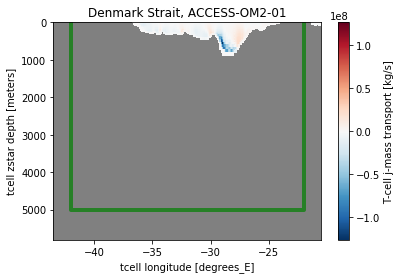

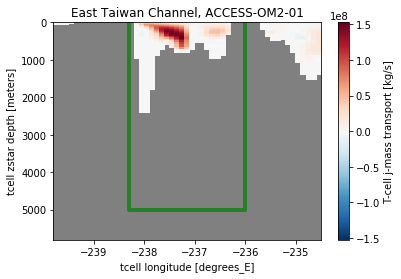

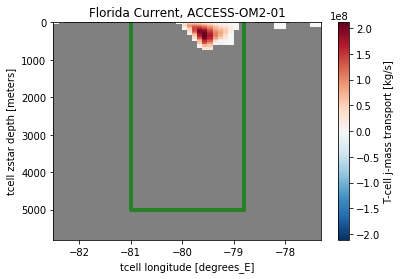

In [10]:
# plot vertical slices at transect locations
m = 1.5 # margin (degrees)
for ekey in data.keys():
    print(ekey)
    e = data[ekey]
    for strait, (xmin, xmax, ymin, ymax) in e['straits'].items():
        print(strait)
        fig, ax = plt.subplots(nrows=1, ncols=1)
        ax.set_facecolor('gray')  # gray land points
        if xmin == xmax:
            e['tx_trans'].isel(time=-1)\
                                .sel(xu_ocean=xmin, method='nearest')\
                                .sel(yt_ocean=slice(ymin-m, ymax+m))\
                                .plot()
            plt.plot([ymin, ymin, ymax, ymax], [0, 5000, 5000, 0],
                color='green', linewidth=4, alpha=0.7)
        elif ymin == ymax:
            e['ty_trans'].isel(time=-1)\
                                .sel(xt_ocean=slice(xmin-m, xmax+m))\
                                .sel(yu_ocean=ymin, method='nearest')\
                                .plot()
            plt.plot([xmin, xmin, xmax, xmax], [0, 5000, 5000, 0],
                color='green', linewidth=4, alpha=0.7)
        else:
            raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
        plt.title(strait+', '+e['desc'])
        plt.gca().invert_yaxis()

In [11]:
# calculate mass transport timeseries(kg/s)
for ekey in data.keys():
    print(ekey)
    e = data[ekey]
    if 'transport' not in e:
        e['transport'] = dict()
    for strait, (xmin, xmax, ymin, ymax) in e['straits'].items():
        if strait not in e['transport']:
            if xmin == xmax:
                e['transport'][strait] = e['tx_trans_int_z'].sel(xu_ocean=xmin, method='nearest')\
                                    .sel(time=slice(tstart,tend))\
                                    .sel(yt_ocean=slice(ymin, ymax))\
                                    .sum('yt_ocean')
            elif ymin == ymax:
                e['transport'][strait] = e['ty_trans_int_z'].sel(yu_ocean=ymin, method='nearest')\
                                    .sel(time=slice(tstart,tend))\
                                    .sel(xt_ocean=slice(xmin, xmax))\
                                    .sum('xt_ocean')
            else:
                raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
        print(strait, e['transport'][strait].mean('time').values/1e6/1036, 'Sv')

01deg
Denmark Strait -4.663369637065637 Sv
East Taiwan Channel 20.70238196138996 Sv
Florida Current 20.443013436293437 Sv


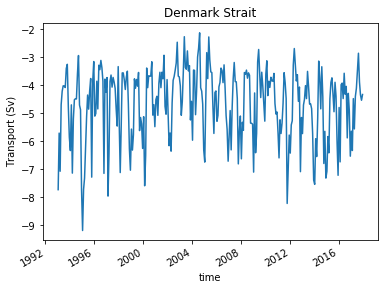

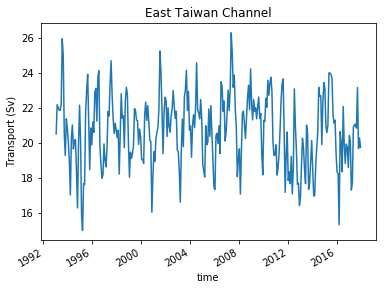

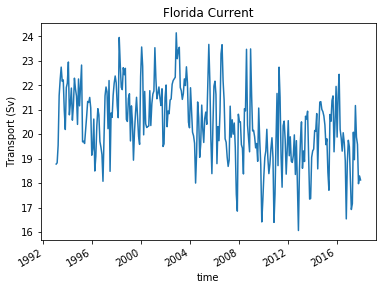

In [15]:
for ekey in data.keys():
    e = data[ekey]
    for strait in e['straits'].keys():
        plt.figure()
        transport = e['transport'][strait]/1e6/1036
        transport.plot()
        plt.title(strait)
        plt.ylabel('Transport (Sv)')
        plt.gca().autoscale()
        savefigure(strait.replace(' ', '_'))
#         break

In [13]:
STOPHERE

NameError: name 'STOPHERE' is not defined

# TODO: fix the following to use the new data structures defined above

In [ ]:
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

for strait, (xmin, xmax, ymin, ymax) in straits_01deg.items():

    plt.plot([xmin, xmax], [ymin, ymax],
            color='red', linewidth=4, alpha=0.5,
             transform=ccrs.Geodetic() )
   
    plt.annotate(xy=(xmin, ymin), xycoords='data',
                 xytext=(xmax+2, ymax),
                 s=strait,
               #  arrowprops=dict(facecolor='black', shrink=0.05),
                 transform=ccrs.Geodetic(),
                clip_on=True)

#ax.set_global()
#plt.annotate(xy=(0, 0), s='origin', transform=ccrs.Geodetic())
#plt.show()


In [ ]:
##@memory.cache
def calc_transport(ekey, strait):
    """
    Calculate barotropic transport across a given 
     line of latitude or longitude.
     
    Designed for flow through straits.
    """
    
    expt = exptdata.exptdict[ekey]['expt']
    n = None #exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    print('Calculating {} {} transport'.format(expt, strait))
    print('with {} files, time units of {} and offset of  {} days'.format(n, time_units, offset))
    
    straits = straits[ekey]['straits']
#     if ekey=='1deg':
#         straits=straits_1deg
#     if ekey=='025deg':
#         straits=straits_025deg
#     if ekey=='01deg':
#         straits=straits_01deg
    
    xmin, xmax, ymin, ymax = straits[strait]
    
    if xmin == xmax:
        tx_trans = cc.get_nc_variable(expt, 
                                'ocean_month.nc', 
                                'tx_trans_int_z',
                                 n=n,
                                 time_units=time_units, offset=offset)
        
        transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('yt_ocean')

    elif ymin == ymax:
        ty_trans = cc.get_nc_variable(expt, 
                                      'ocean_month.nc', 
                                      'ty_trans_int_z',
                                      n=n,
                                      time_units=time_units, offset=offset)
        transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
                            .sel(xt_ocean=slice(xmin, xmax))\
                            .sum('xt_ocean')
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    
    transport = transport.compute()
       
    return transport

### A plot for Indonesian Seas only

In [ ]:
%%time
itf_straits = ['Lombok Strait', 'Ombai Strait',  'Timor Strait']
results = []
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    desc = exptdata.exptdict[ekey]['desc']
    for i, strait in enumerate(itf_straits):
# convert from kg/s to Sv, assuming typical in-situ density of 1036kg/m^3
# https://www.nature.com/scitable/knowledge/library/key-physical-variables-in-the-ocean-temperature-102805293
        transport = calc_transport(ekey, strait)/1e6/1036
        transport_mean = transport.resample(time='A').mean('time')
        
        result = {'transport_mean': transport_mean,'expt': expt,'desc': desc,'i': i}
        results.append(result)

IPython.display.clear_output()

In [ ]:
plt.figure(figsize=(12,8))
for result in results:
    transport_mean = result['transport_mean']
    desc = result['desc']
    i = result['i']
    
    if i==0:
        total_transport = transport_mean
    else:
        total_transport = total_transport+transport_mean
        
    plt.subplot(2, 2, i+2)
    transport_mean.plot(label=desc, linewidth=2)
    plt.ylabel('')
    plt.gca().autoscale()

    if i ==2:
        plt.subplot(221)
        total_transport.plot(label=desc, linewidth=2)
        plt.title('(a) Total ITF')
        plt.ylabel('')
        plt.gca().autoscale()

for k in range(1,i+2,2):
    plt.subplot(2, 2, k)
    plt.ylabel('Transport (Sv)')

for k in range(1,3,1):
    plt.subplot(2, 2, k)
    plt.xlabel('')
    plt.gca().axes.xaxis.set_ticklabels([])

plt.subplot(221)
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[-14, -14],'k--',label="INSTANT")
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.legend()

plt.subplot(222)
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[-2.6, -2.6],'k--',label="INSTANT")
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('(b) '+itf_straits[0])

plt.subplot(223)
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[-4.9, -4.9],'k--',label="INSTANT")
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('(c) '+itf_straits[1])

plt.subplot(224)
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[-7.5, -7.5],'k--',label="INSTANT")
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('(d) '+itf_straits[2])

savefigure('ITF_transport')

# Drake Passage Transport

In [ ]:
%%time
strait = 'Drake Passage'
results = []
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    desc = exptdata.exptdict[ekey]['desc']
    transport = calc_transport(ekey, strait)/1e6/1036
    transport_mean = transport.resample(time='A').mean('time')
    result = {'transport_mean': transport_mean,'expt': expt,'desc': desc}
    results.append(result)

IPython.display.clear_output()
    

In [ ]:
def add_cycles(ax):
    cycle_dates = [1718, 1778, 1838, 1898, 1958, 2018]
    ylims=ax.get_ylim()
    for cd in cycle_dates:
        ax.plot([pd.datetime(cd,1,1),pd.datetime(cd,1,1)],ylims,'k--',linewidth=0.8)
    ax.set_ylim(ylims)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(9,4))
fig.subplots_adjust(wspace=0.0)
for result in results:
    transport_mean = result['transport_mean']
    desc = result['desc']
    transport_mean.plot(ax = ax[0],label=desc, linewidth=2)
    transport_mean.plot(ax = ax[1],label=desc, linewidth=2)

    
ax[0].plot([pd.datetime(1718,1,1),pd.datetime(1957,12,31)],[173, 173],'k--',label="Donohue et al. (2016)")
ax[1].plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[173, 173],'k--',label="Donohue et al. (2016)")
l2=ax[1].legend(fancybox=True, framealpha=0.75)
ax[0].set_xlim([pd.datetime(1718,1,1),pd.datetime(1957,12,31)])
ax[0].set_xticks([pd.datetime(1730,1,1), pd.datetime(1740,1,1), pd.datetime(1750,1,1), pd.datetime(1770,1,1), 
               pd.datetime(1780,1,1), pd.datetime(1790,1,1), pd.datetime(1810,1,1), pd.datetime(1820,1,1), 
               pd.datetime(1830,1,1), pd.datetime(1850,1,1), pd.datetime(1860,1,1), pd.datetime(1870,1,1),
               pd.datetime(1890,1,1), pd.datetime(1900,1,1), pd.datetime(1910,1,1), pd.datetime(1930,1,1),
               pd.datetime(1940,1,1), pd.datetime(1950,1,1)], minor=True)
ax[1].set_xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
ax[0].set_title('')
ax[1].set_title('Drake Passage Transport',position=(0.0,1.0))
ax[0].set_xlabel('')
ax[1].set_xlabel('Year',position=(0.0,1.0))
ax[0].set_ylabel('Transport (Sv)')
ax[1].set_yticks([])
ax[1].set_ylabel('')

add_cycles(ax[0])

savefigure('DP_transport')

------

# Below here, not used for manuscript

## EAC and Florida Str

In [ ]:
%%time
strait = 'Florida Strait'
results = []
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    desc = exptdata.exptdict[ekey]['desc']
    transport = calc_transport(ekey, strait)/1e6/1036
    transport_mean = transport.resample(time='A').mean('time')
    result = {'transport_mean': transport_mean,'expt': expt,'desc': desc}
    results.append(result)

IPython.display.clear_output()
    

In [ ]:
def add_cycles(ax):
    cycle_dates = [1718, 1778, 1838, 1898, 1958, 2018]
    ylims=ax.get_ylim()
    for cd in cycle_dates:
        ax.plot([pd.datetime(cd,1,1),pd.datetime(cd,1,1)],ylims,'k--',linewidth=0.8)
    ax.set_ylim(ylims)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(9,4))
fig.subplots_adjust(wspace=0.0)
for result in results:
    transport_mean = result['transport_mean']
    desc = result['desc']
    transport_mean.plot(ax = ax[0],label=desc, linewidth=2)
    transport_mean.plot(ax = ax[1],label=desc, linewidth=2)

    
ax[0].plot([pd.datetime(1718,1,1),pd.datetime(1957,12,31)],[173, 173],'k--',label="Donohue et al. (2016)")
ax[1].plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[173, 173],'k--',label="Donohue et al. (2016)")
l2=ax[1].legend(fancybox=True, framealpha=0.75)
ax[0].set_xlim([pd.datetime(1718,1,1),pd.datetime(1957,12,31)])
ax[0].set_xticks([pd.datetime(1730,1,1), pd.datetime(1740,1,1), pd.datetime(1750,1,1), pd.datetime(1770,1,1), 
               pd.datetime(1780,1,1), pd.datetime(1790,1,1), pd.datetime(1810,1,1), pd.datetime(1820,1,1), 
               pd.datetime(1830,1,1), pd.datetime(1850,1,1), pd.datetime(1860,1,1), pd.datetime(1870,1,1),
               pd.datetime(1890,1,1), pd.datetime(1900,1,1), pd.datetime(1910,1,1), pd.datetime(1930,1,1),
               pd.datetime(1940,1,1), pd.datetime(1950,1,1)], minor=True)
ax[1].set_xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
ax[0].set_title('')
ax[1].set_title('Florida Current Transport',position=(0.0,1.0))
ax[0].set_xlabel('')
ax[1].set_xlabel('Year',position=(0.0,1.0))
ax[0].set_ylabel('Transport (Sv)')
ax[1].set_yticks([])
ax[1].set_ylabel('')

add_cycles(ax[0])

savefigure('Florida_Current_transport')

## other stuff

In [ ]:
ncols = 2
nrows = math.ceil(len(straits)/ncols)
tstart = 1e10
tend = -1e10
# transports = copy.deepcopy(exptdata.exptdict)  # this will store speed fields under the same keys as exptdata.exptdict
plt.figure(figsize=(12,10))
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    desc = exptdata.exptdict[ekey]['desc']
    for i, strait in enumerate(straits):
# convert from kg/s to Sv, assuming typical in-situ density of 1036kg/m^3
# https://www.nature.com/scitable/knowledge/library/key-physical-variables-in-the-ocean-temperature-102805293
#        if ekey == '01deg':
#            transport = calc_transport(expt, strait,n=410)/1e6/1036
#             tstart = min(tstart, transport['time'].data[0])  # first time in model data
#             tend = max(tend, transport['time'].data[-1])  # final time in model data
#        else:
        transport = calc_transport(ekey, strait)/1e6/1036
        transport_mean = transport.resample(time='A').mean('time')
        plt.subplot(nrows, ncols, i+1)
        transport_mean.plot(label=desc+', annual mean', linewidth=2)
        #transport.plot(label=desc, linewidth=0.2, alpha=0.5)
        plt.title(strait)
        plt.ylabel('')
        plt.gca().autoscale()

for k in range(1,i+2,2):
    plt.subplot(nrows, ncols, k)
    plt.ylabel('Transport (Sv)')

for k in range(1,i,1):
    plt.subplot(nrows, ncols, k)
    plt.xlabel('')
    plt.gca().axes.xaxis.set_ticklabels([])

# for k in range(1,i+2,1):
#     plt.subplot(nrows, ncols, k)
#     plt.gca().xlim([tstart, tend])

plt.subplot(nrows, ncols, i+1)
plt.legend(bbox_to_anchor=(-0.1,-0.25), loc='upper center')

savefigure('strait_transports')

In [ ]:
ekey = '025deg'
expt = exptdata.exptdict[ekey]['expt']
n = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
n=30
offset=0
tx_trans = cc.get_nc_variable(expt, 
                                'ocean_month.nc', 
                                'tx_trans_int_z',
                                 n=n,
                                 time_units=time_units, offset=offset)
        

In [ ]:
xmin, xmax, ymin, ymax = straits_025deg['Ombai Strait']

transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))

transport.sum('yt_ocean').resample(time='A').mean('time').plot()
print(transport.mean('time').sum('yt_ocean').values)


In [ ]:
temp = transport.sum('yt_ocean').resample(time='A').mean('time')



In [ ]:
temp.plot(label='last cycle')
transport.sum('yt_ocean').resample(time='A').mean('time').plot(label='first cycle')
plt.legend()

In [ ]:
n